## Twitter US Airlines Sentiment 
Challenge: To apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment

This problem is a straightforward language analysis problem, and a good exercise to learn how to filter noisy Data. Often text data that we will analyse will have lots of unnecessary characters and information which is not relevant to the goal of the modeling exercise. This problem reminds us to always view data from that perspective.

Text classification can be carried out as unsupervised or supervised.
In this case, clearly we are going to use supervised learning as we are using the labels in the columns while training the model.

In case of unsupervised model, we would just provide it the various reviews and ask the model to learn.

I could not find a SOTA reference for this challenge, although it is a very popular problem on various forums at Kaggle, Medium etc
Most of the references though are using Machine Learning Algorithms such as decision trees, Naive Bayes or Logistic Regression etc. 
However this challenge asked us to use Fast.ai's AW-LSTM Model.

There are no visualizations for this , also there is not much need for feature engineering for this Deep Learning problem. FE was usually applicable for mathematical data or data which can be operated upon. 

We have used TextClassificationInterpretation to interpret the task.

### As regards modeling techniques, we train the model in two steps-
### 1. We first fine-tune a language model, which is previously trained on Wikipedia text, on the twitter dataset.
### 2. We use this language model as an encoder (word embeddings) and train a classifier model.

The AWD-LSTM Model is a basic model, unlike the Transformer Model 

We solve a sentiment analysis problem using the fastai library.

This Twitter data was scraped from February of 2015 and contributors were asked to first classify tweets. It contains 14640 texts with label of postive, negative or neutral sentiment. The maximum size of a text is 280 characters which is the limit in Twitter.


# Check the GPU

In [ ]:
# Check the GPU
!nvidia-smi

Sun Jul 19 12:06:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
# fastai library for NLP
from fastai.text import *

import pandas as pd

# Load the Dataset

In [ ]:
# Mount google drive to access its files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Provide path to the csv file
path = 'drive/My Drive/Fellowship.ai/Sentiment Analysis/Tweets.csv'

Print the original csv file to understand the dataset

In [ ]:
# Read the csv file into a pandas dataframe
df = pd.read_csv(path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Since we only need the text and sentiment from the csv file, we copy these two columns to a separate pandas dataframe

In [ ]:
df2 = pd.DataFrame({'label':df['airline_sentiment'], 'text':df['text']})

We save the dataframe file as a csv file

In [ ]:
# Save the file as csv without the index column
df2.to_csv('data.csv', index=False)

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
# Number of tweets
len(df)

14640

#Clean Data
This dataset has a column named text which contains the tweets from customers for a particular airline and a label which tells whether the tweet has a positive, neutral or negative sentiment.

# Language Model

We first have to convert the words into numbers. This is done in two steps-
1. Tokenization - We split the entire text using spaces, punctuations, special symbols etc. as delimiters.
2. Numericalization - We convert these tokens to a dictionary format where the key is the word and value is the number associated to it.

The fastai library will automatically launch the tokenization process with the spacy tokenizer and a few default rules for pre and post-processing before numericalizing the tokens.

### When we call TextLMDataBunch function of Fast.ai, all this is done behind the scenes.

In [ ]:
path = ''
data_lm = TextLMDataBunch.from_csv(path, 'data.csv')



```
# This is formatted as code
```

When we display a batch, there are no y_labels as we only need the text to build the vocabulary.

In [ ]:
data_lm.show_batch()

idx,text
0,". xxmaj thank you xxbos @americanair welcome anyone who works in those conditions deserves a thank you even though i am other side of # xxmaj atlantic lol xx xxbos @united xxmaj good evening , xxup ua . xxmaj can you assist with an issue via xxup dm ? xxbos @usairways thanks for getting us on ur plane . xxmaj awesome flight attendant who is making us smile after difficult"
1,"'s y all corporate number bc y all are not trying to accommodate me at all ! ! ! xxbos @jetblue xxmaj love your airline ... hate your website . xxmaj just tried to book 2 tickets ( 1 w miles , 1 w / out ) . xxmaj absolute joke . xxmaj needs a lot of work ! xxbos @united 129 thousand fans of @jedediahbila are asking you to"
2,"@usairways i submitted refund request b4 1st flight 2 days ago . xxmaj is that all i need 2 do ? xxbos @united thanks for the reply . xxmaj to clarify , the airfare is similar to your likely intended xxunk group . xxmaj the $ 3 beer charge , however , is not xxbos @united we were not given the option of using our xxmaj united xxunk in a"
3,simply amazing . xxmaj xxunk for miles . xxmaj thank u for my upgrade tomorrow for xxunk are spending a lot of time together next few weeks ! xxbos @jetblue i did not report the updated info - do n't know how to reach them without a super long wait on hold at your main number . xxbos @southwestair # destinationdragons xxmaj any word on winners of contest ? xxmaj
4,"they do n't want to honor my flight . xxbos @usairways xxmaj thank you , @usairways ! xxmaj your fare to from xxup dtw to xxup dca was much lower than @delta and @southwestair ! xxmaj thank you ! xxmaj you won me over ! xxbos @southwestair and thx for not responding xxbos @jetblue xxmaj only middle seats . xxup sfo - > xxup bos . xxmaj not fun ."


There are quite a few strange tokens starting with xx. These are special FastAI tokens that have the following meanings:

    xxunk: Token used instead of unknown words (words not found in the vocabulary).
    xxbos: Beginning of a text.
    xxfld: Represents separate parts of your document (several columns in a dataframe) like headline, body, summary, etc.
    xxmaj: Indicates that the next word starts with a capital, e.g. “House” will be tokenized as “xxmaj house”.
    xxup: Indicates that next word is written in all caps, e.g. “WHY” will be tokenized as “xxup why ”.
    xxrep: Token indicates that a character is repeated n times, e.g. if you have  10 $ in a row it will be tokenized as “xxrep 10 $” (in general “xxrep n  {char}”)
    xxwrep: Indicates that a word is repeated n times.
    xxpad : Token used as padding (so every text has the same length)

In [ ]:
# Print the first 30 items in the vocabulary
data_lm.vocab.itos[:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 'a',
 '?',
 'you',
 '/',
 ',',
 'for',
 'flight',
 '@united',
 'on',
 'and',
 '#',
 'my',
 '@usairways',
 '@americanair',
 'is',
 'in']

In [ ]:
# Sanity print check the data in language model
data_lm.train_ds

LabelList (11711 items)
x: LMTextList
xxbos @usairways it 's not like i 'm trying to leave earlier just for fun . i do n't want to get stuck in xxup dc if we have bad weather in xxup rdu .,xxbos @united xxmaj will do ! xxmaj thanks !,xxbos @jetblue unfortunately i was so xxunk and rushed , i did n't get the name , but will provide a xxunk in my xxunk email . xxmaj thank you,xxbos @americanair welcome anyone who works in those conditions deserves a thank you even though i am other side of # xxmaj atlantic lol xx,xxbos @united xxmaj good evening , xxup ua . xxmaj can you assist with an issue via xxup dm ?
y: LMLabelList
,,,,
Path: .

In [ ]:
# Print the Numericalization data i.e. numbers associated with the words
data_lm.train_ds[0][0].data

array([  2,  26,  31,  44,  41, 119,  11,  82, 141,  10, 355, 419,  64,  19, 965,   9,  11,  47,  34, 188,  10,  49,
       246,  29,   6, 632,  87,  51,  37, 238, 150,  29,   6, 820,   9])

Finally, we will load this data into a learner object with a model having pretrained weights

## AWD LSTM 

As such, AWD-LSTM has been dominating the state-of-the-art language modeling. A lot of top research papers on word-level models incorporate AWD-LSTMs. And it has shown great results on character-level models as well.

Since we are using a small dataset with a max size of 280 characters in a sample, a regularized and optimized LSTM model should be more than sufficient to achieve good results. It serves the purpose to form and remember the context by having long short-term memory, earlier missing in simple RNNs.

The fast.ai's universal language model ULMfit uses Stephen Merity’s Wikitext 103 dataset, which contains a pre-processed large subset of English Wikipedia. This helps us leverage the power of word embeddings, which further helps the model to understand and associate a text to a particular sentiment.

### Fast.ai's ULMFit Model uses the AWD-LSTM architecture and applies the appropriate weights using the language_model_learner wrapper.

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


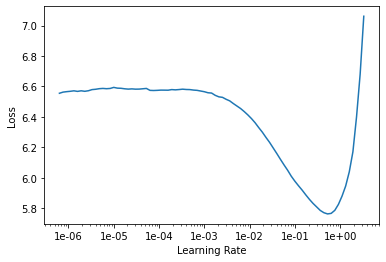

In [ ]:
# plot the range
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.721487,4.074032,0.249895,00:07


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

Unfreeze the model and train further for fine-tuning.

In [ ]:
# Set every layer group to trainable
learn.unfreeze()

### Learning rate is critical.
LR >> Validation Loss too High

LR << Error Rate improves slowly, long time to train (refit) 

Epochs >> Overfit, ER too high

Epochs << Training Loss more than Validation Loss, ER improves (refit)

We use the fastai learning rate finder to glean a good starting point for a learning rate. Consider the point where the loss just begins to taper (slope)

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.002950,3.897451,0.274068,00:08
1,3.861327,3.762355,0.289076,00:08
2,3.706820,3.695446,0.297610,00:09
3,3.483981,3.664596,0.301064,00:09
4,3.237294,3.684798,0.300433,00:09
5,2.962875,3.743228,0.298004,00:09
6,2.700261,3.800833,0.295890,00:09
7,2.485629,3.876554,0.293015,00:09
8,2.336885,3.915147,0.291912,00:08
9,2.254760,3.926724,0.291268,00:09


We get an accuracy of almost 29% which means our model is able to predict the next word in a sentence with a probability of 29%.

We do a sanity check and see how good our model is by seeing what it predicts after a few given words

In [ ]:
TEXT = "I liked this airline because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this airline because they are helpful and provide small services in my business . Too bad i love you xxbos @united i 'm flying home tonight , but i 've been stuck in Chicago with no gate agent yet , ca
I liked this airline because of your planes ! Awesome ! Thank you ! xxbos @united i 'm talking about my Cancelled Flighted flight and the phone line . What gives ? xxbos @jetblue Thank you for the


# Language Model Inference
### When a given a simple sentence with just 5 words, the model is able to complete the sentence to the required number of words. 

### This sentence prediction seems grammatically very accurate with a good use of different parts of speech at the right places. However, the context does not make much sense right now.

### We leverage this power to train our classifier model quite easily, as the model now just has to learn to associate a text to a particular label.



In [ ]:
# We save the model as well as its encoder, as this part is responsible for guessing the next word.
learn.save_encoder('fine_tuned_enc')

# Classifier Model

We create a new data object that grabs the labelled data and keeps those labels. We also use our vocabulary from the language model as we'll be loading the encoder.

In [ ]:
data_clas = TextClasDataBunch.from_csv(path, 'data.csv', vocab=data_lm.vocab) 

In [ ]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
"xxbos @usairways yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here .",negative


#Create Text Classification Model 

With our language model ready and the encoder saved, we can now create a text classification model, load in the encoder we saved before, and train the network.


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @united okay . xxmaj thanks .,xxbos @jetblue i will . i love flying with you all . xxmaj great service .,xxbos @southwestair xxmaj love xxmaj southwest . xxmaj you guys have been good to me ! http : / / t.co / xxunk,xxbos @united xxmaj never can get a flight out on time . 4 hour delay earlier another hour delay on my connecting flight . xxmaj makes 10 straight delays,xxbos @usairways @jack_kairys ( 2 / 2 ) and another sent him to the wrong line ... oh and the kiosks were n't working ! # thanks
y: CategoryList
neutral,positive,positive,negative,negative
Path: .;

Valid: LabelList (2929 items)
x: TextList
xxbos @united i flew back w other company since xxmaj united did nt have an earlier flight,xxbos @united tried to book a flight xxup iah - xxup xxunk departing 3 / 31 / 15 returning 4 / 17 / 15 you are advertising 9 flights for $ 1051 that ca n't be book !,xxbos @virginamerica requested window seat and 

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


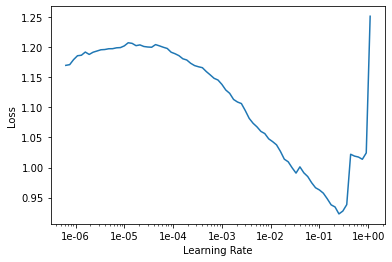

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.667757,0.523368,0.790714,00:05
1,0.582983,0.534837,0.794128,00:05


## Fine-tuning model

We unfreeze the model layer by layer for better fine-tuning.

*Note*: Here I tried several options and the default Fast.ai Divisor 10, but I also found a Hyper Parameter divisor which seems to have worked well for others in the community. I tried the same and it worked well in this case too, hence I decided to use 2.6**4 as my divisor

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.590327,0.509854,0.803687,00:06
1,0.498216,0.476655,0.816661,00:06


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.491309,0.473672,0.820075,00:09
1,0.339011,0.509069,0.824172,00:08


We unfreeze the model completely and train.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.262461,0.519975,0.827245,00:11
1,0.227206,0.556426,0.811540,00:11
2,0.164258,0.602784,0.817685,00:11
3,0.141637,0.620743,0.818027,00:11
4,0.126593,0.621162,0.818368,00:11


## Final Accuracy - **82.7%** 

As such, we can improve the model by playing with the hyper parameters. However, I decided to stop here I observed that the Accuracy was falling after more epochs. We also see the Error Rate increases as the epochs increase, which could suggest overfit, however, in this case it does not change but remains fairly constant. This means overfitting is not really an issue, keeing in mind the inbuilt regularization of the AWD-LSTM model 

# Model Evaluation

In [ ]:
interp = TextClassificationInterpretation.from_learner(learn) 

In [ ]:
for i in range(5):
  x = interp.show_intrinsic_attention(df.loc[i])
  print(x)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


None


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


None


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


None


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


None


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


None


The colors show how the model is interpreting the ingest data. The model assigns weights ranging from -1 to 1 corresponding to different colors.
e.g. Model assigns similar context to all text having same color, and gives relative importance to the darker shaded text when interpreting data 

Green - The attention colors show that nouns and adjectives like '@virginamerica', 'commericial', 'big', 'trip' have similar weights. It also captures relevant some short verbs like 'did not', 'blast', 'take' in lighter colors.

Red - The fastai special tokens have similar weights. Also, some verbs like 'have', 'it is' and smaller words like 'your', 'and, 'it' take lighter colors.




# Model Prediction

We run the model prediction on some sample tweets.

In [ ]:
data_clas.classes

['negative', 'neutral', 'positive']

In [ ]:
# Positive Tweet
learn.predict("@Virgin I really loved that airline, it was awesome!")

(Category tensor(2), tensor(2), tensor([7.7929e-05, 1.0337e-07, 9.9992e-01]))

In [ ]:
# Negative Tweet
learn.predict("@Toronto I do not enjoy taking flights from this airport")

(Category tensor(0), tensor(0), tensor([9.9996e-01, 2.9250e-05, 9.1083e-06]))